In [1]:
##### mosquito tracking by Felix Hol


%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import itertools as it
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
from skimage import data, io
from skimage.feature import match_template
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)
from skimage.color import rgb2gray
from skimage import util
import skimage
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, disk, black_tophat, skeletonize, convex_hull_image
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import trackpy as tp
import pylab

# Optionally, tweak styles. 
# mpl.rc('figure',  figsize=(10, 6))
#mpl.rc('image', cmap='gray')

dataDir = '/home/felix/MosquitoData/wellPlateBites/180330_Zik_plate1_01/data'
saveDir = '/home/felix/MosquitoData/wellPlateBites/180330_Zik_plate1_01/processed'

frames = pims.ImageSequence(dataDir+'/*.jpg', as_grey=True)

In [2]:
#### Make background image BG

j = 1
frameSize = frames[1].shape
BG = np.zeros(frameSize)


##### pick an interval over which you would like to make the background image (could be the whole stack or a subset)

for i in range(100, 5500, 200):
    j += 1
    BG = BG + np.invert(frames[i])


#### Use this loop in case you want to make a background image using several subsets of the stack
    
# for i in it.chain(range(100,300,5), range(738,1007, 10)):
#     j += 1
#     BG = BG + np.invert(frames[i])
    
BG = BG / j

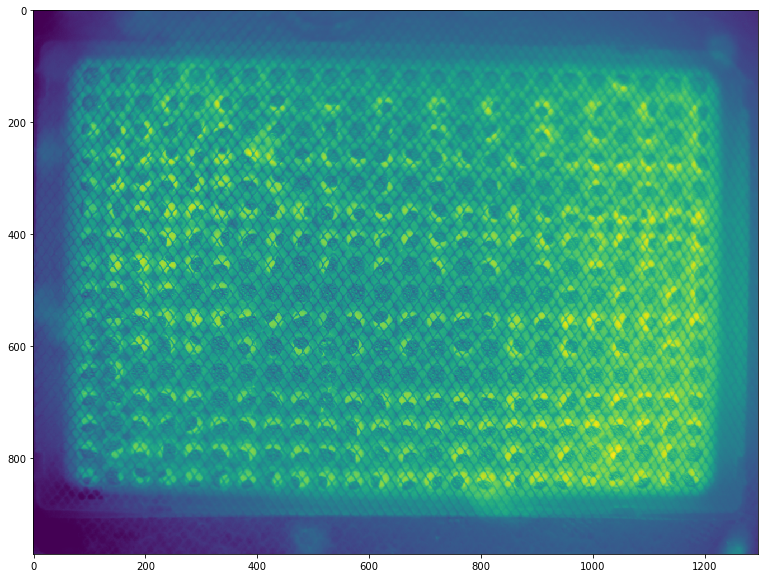

In [3]:
plt.figure(figsize=(25,10))
plt.imshow(BG)

In [4]:
np.max(BG)

141.60714285714286

In [76]:
selem1 = disk(8)
selem2 = disk(1)

coordinatesAll = np.zeros((1,3))
frameSize = frames[1].shape
BGbefore = 20 #### these three values are only used if the background image is recalculated for every frame
BGafter = 11
BGstep = 4


##whole set from 1 - 5595, first test with subset

for i in range(10,109):
#     BG = np.zeros(frameSize) ##### use the commented section if you need to make a background image from a sliding window stack
#     j = 0
#     for k in it.chain(range(i-BGbefore, i+BGafter, BGstep), range(i+300, i+500, 20) ):
#         j += 1
#         BG = BG + np.invert(frames[k])
#     BG = BG / j
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    Bm = B - B.min()
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 40 ##### This umber depends on camera settings
    Be = erosion(Bt, selem2)
    Bf = remove_small_objects(Be, min_size=10)
    #Be = erosion(Bf, selem2)
    C = B * Bf
    eroded = erosion(C, selem2)
    #eroded = erosion(eroded, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    eroded = erosion(eroded, selem2)
    #eroded = eroded.astype(np.uint8)
    #print(eroded.shape)
    #image_max = ndi.maximum_filter(eroded, size=80, mode='constant')
    coordinates = peak_local_max(eroded, min_distance=20, exclude_border=1)
    cS= coordinates.shape; numCoor = cS[0]
    frameNo = i
    frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoA[:] = frameNo
    coordinatesF = np.hstack((coordinates,frameNoA))
    coordinatesAll = np.vstack((coordinatesAll,coordinatesF)) 
#     os.chdir(saveDir)  #### use this section in case you want to make a movie plotting coordinates
#     plt.imshow(frames[i], cmap=plt.cm.gray)
#     plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
#     plt.xlim([0,2592])
#     plt.ylim([0,1944])
#     plt.savefig("coorIm" + str(i).zfill(6) + ".png",dpi=200)
#     plt.figure(1)
#     plt.imshow(np.flipud(frames[i]), cmap=plt.cm.gray)
#     plt.autoscale(False)
#     plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
#     plt.show()


#### final output coordinatesAll can be used as input of trackpy
df = pd.DataFrame(coordinatesAll)



[[ 832 1207 1090]
 [ 746  487 1090]
 [ 702 1057 1090]
 [ 689  921 1090]
 [ 621 1134 1090]
 [ 452 1212 1090]
 [ 394  449 1090]
 [ 387  770 1090]
 [ 347 1273 1090]
 [ 290  429 1090]
 [ 247  928 1090]
 [ 116  597 1090]
 [  92 1099 1090]]
94.5


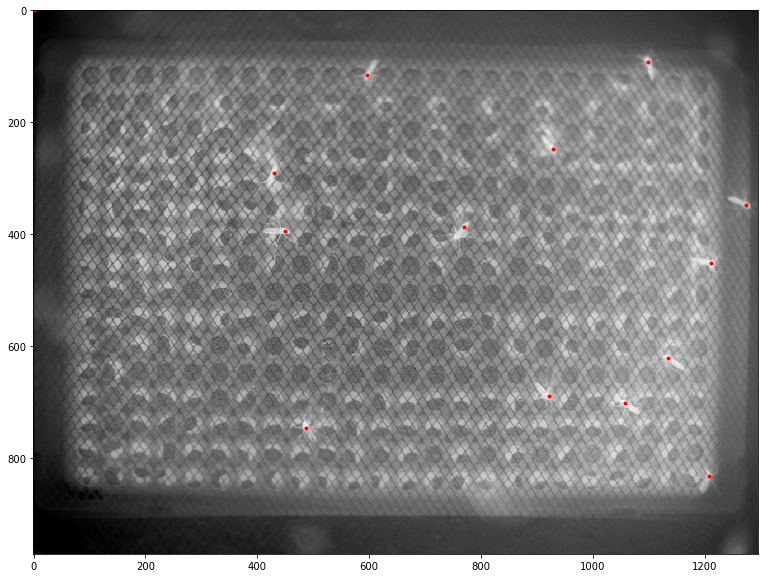

In [78]:
plt.figure(figsize=(25,10))
plt.imshow(A, cmap = 'gray')
plt.plot(coordinatesAll[:,1],coordinatesAll[:,0],'r.')
print(coordinatesF)
print(Bm.max())
# plt.savefig('180323_AeAZIKV_plate3_coor01.png',dpi=300)

In [82]:
#from tempfile import TemporaryFile
os.chdir(saveDir)
#outfile = TemporaryFile()
np.save('coordinatesAll180330_ZIKVplate1_01.npy', coordinatesAllT)

In [79]:
#### use this section if you want to run the script to find coordinates in parallel. 


from joblib import Parallel, delayed
import multiprocessing

##whole set from 1 - 3965

inputs = range(1,5595)

def mosCoordinate(i):
    selem1 = disk(8)
    selem2 = disk(1)
    frameSize = frames[1].shape
#     BGbefore = 20  #### in case you need adaptive background use following lines
#     BGafter = 11
#     BGstep = 4
#     BG = np.zeros(frameSize)
#     j = 0
#     for k in it.chain(range(i-BGbefore, i+BGafter, BGstep), range(i+300, i+500, 20) ):
#         j += 1
#         BG = BG + np.invert(frames[k])
#     BG = BG / j
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    Bm = B - B.min()
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 40
    Be = erosion(Bt, selem2)
    Bf = remove_small_objects(Be, min_size=10)
    #Be = erosion(Bf, selem2)
    C = B * Bf
    eroded = erosion(C, selem2)
    #eroded = erosion(eroded, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    eroded = erosion(eroded, selem2)
    coordinates = peak_local_max(eroded, min_distance=20, exclude_border=1)

    cS= coordinates.shape; numCoor = cS[0]
    frameNo = i
    frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoA[:] = frameNo
    coordinatesF = np.hstack((coordinates,frameNoA))
    return coordinatesF

num_cores = multiprocessing.cpu_count()
    
results = Parallel(n_jobs=num_cores)(delayed(mosCoordinate)(i) for i in inputs)

coordinatesAllT = np.zeros((1,3))

for i in range(len(results)):
    coordinatesAllT = np.vstack((coordinatesAllT,results[i]))


/home/felix/anaconda3/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/home/felix/anaconda3/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/home/felix/anaconda3/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/home/felix/anaconda3/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_obje

94.5


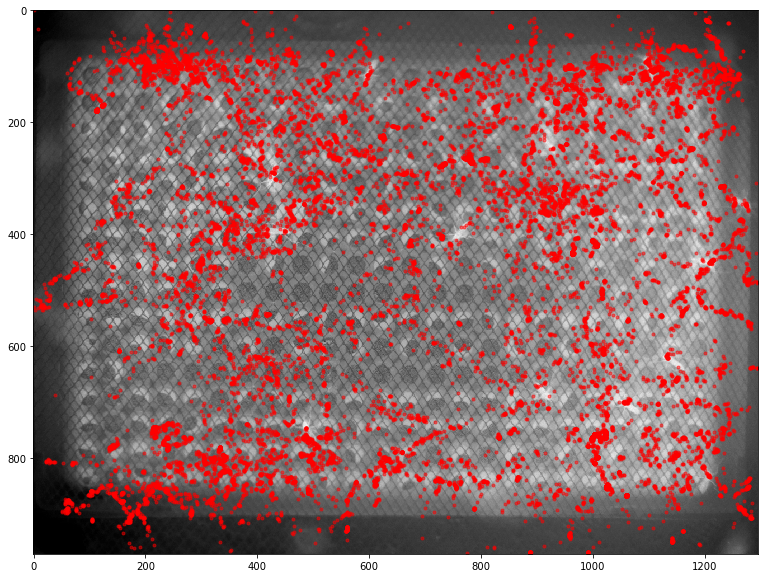

In [81]:
plt.figure(figsize=(25,10))
plt.imshow(A, cmap = 'gray')
plt.plot(coordinatesAllT[:,1],coordinatesAllT[:,0],'r.', alpha = 0.5)
# print(coordinatesF)
print(Bm.max())

In [ ]:
plt.imshow(A ,cmap='gray',alpha=0.99)
mpl.rc('figure',  figsize=(19, 9))
plt.plot(coordinatesAll[:,1],coordinatesAll[:,0],'r.',alpha=0.3)
plt.savefig('180214test_r05.png',dpi=300)


In [ ]:
dfI = pd.DataFrame(coordinatesAll, columns=['y','x','frame'])
dfI.head()

In [ ]:
#### track all coordinates using trackpy
t = tp.link_df(dfI, 50, memory=4)

In [ ]:
for i in range(225,255): 
    #print(i)
    plt.close()
    fig = plt.figure(figsize=[5,5],frameon=False)
    ax = fig.add_axes([0,0,1,1])
   
    implot = ax.imshow(-frames[i],cmap='Greys')    # Greys maps from white to black; I prefer black to white so I negate the image.
    
#     traj_hist =  trajectories_to_show[trajectories_to_show['frame'].between(i-20,i)]

#     for this_particle in tracks_to_show:
#         this_traj_hist = traj_hist[traj_hist.particle == this_particle]
#         this_xcoords_hist = this_traj_hist['x']
#         this_ycoords_hist = this_traj_hist['y']
#         plt.plot(this_xcoords_hist.values,this_ycoords_hist.values, 'r-', alpha=0.4)

    thisframefavcoords = trajectories_to_show[trajectories_to_show.frame ==i]
    xcoords = thisframefavcoords['x']
    ycoords = thisframefavcoords['y']
    plt.plot(xcoords.values,ycoords.values, 'r.', alpha=0.2)
    
    plt.ylim(1944,0)
    plt.xlim(0,2592)
    plt.xticks([],'')
    plt.yticks([],'')
    os.chdir(saveDir2)
    plt.savefig("trackIm" + str(i).zfill(6) + ".png",dpi=200)

In [ ]:
os.chdir(saveDir)
fig1 = plt.figure(figsize=(25,10))
plt.imshow(frames[1], cmap='gray')
plt.plot(coordinatesAll[:,1],coordinatesAll[:,0],'r.',alpha=0.5, markersize=10)
tp.plot_traj(t, plot_style={'linewidth':'1.0'})
fig1.savefig("180221_coorIm01.pdf", bbox_inches='tight')

In [ ]:
saveDir3 = '/home/felix/MosquitoData/wellPlateBites/180221_wellGel01/processing/movie'
os.chdir(saveDir3)

##whole set from 100 - 7880

for i in range(100,7880):
    plt.close()
    fig = plt.figure(figsize=[9,6],frameon=False)
    frameCoor = np.where(coordinatesAll[:,2] == i)
    plt.imshow(frames[i],cmap='gray',alpha=0.99)
    if np.sum(np.where(coordinatesAll[:,2] == i)) > 0:
        plt.plot(coordinatesAll[frameCoor,1],coordinatesAll[frameCoor,0],'r.',alpha=0.99)
        plt.savefig("coorIm" + str(i).zfill(6) + ".jpg", bbox_inches='tight', dpi = 250)
    

In [ ]:
t1 = tp.filter_stubs(t2, 4)
t1.head()

In [ ]:
# plt.imshow(BG,cmap='gray',alpha=0.75)
#mpl.rc('figure',  figsize=(19, 19))
os.chdir(saveDir)
niceLine = {'linewidth':'1.5','color':'r'}
fig1 = plt.figure()
tp.plot_traj(t2,colorby='particle',superimpose=(Ar ), plot_style={**niceLine})
fig1.savefig('171206_5pix_01.png')

In [ ]:
from skimage.draw import circle
from skimage.measure import label, regionprops
from skimage.color import label2rgb

x_topleft = 161
y_topleft = 117
pitch = 46
#y_pitch = 188
x_tilt = np.floor(-12 / 23)
y_tilt = np.floor(2 / 7)
num_rows = 16
num_columns = 24
radius = 23
wells = np.zeros((972,1296), dtype=np.double)

for i in range(num_rows):
    for j in range(num_columns):
        x = x_topleft + j * pitch + i * y_tilt
        y = y_topleft + i * pitch + j * x_tilt
        cc = circle(y, x, radius, wells.shape)
        wells[cc] = 1
        
well_labels = label(wells)

In [ ]:
def getWellMosCount(coordinatesAll, well_labels):
    
    coorShape = coordinatesAll.shape
    wellMosCount = np.zeros(well_labels.max())
    
    COOR = coordinatesAll.astype(np.int16)
    
    for i in range(20):#coorShape[0]):
        #print(i)
        
        for j in range(1,1 + well_labels.max()):
            wellI = np.where(well_labels == j)
            thisWell=np.vstack((wellI[0],wellI[1]))
            thisWell = thisWell.T
            
            if np.any(COOR[i,0] == thisWell[:,0]) and np.any(COOR[i,1] == thisWell[:,1]):
                wellMosCount[j-1] += 1
                
    return wellMosCount
    

In [ ]:
plt.figure(1)
plt.ylim([0,2592])
plt.xlim([0,1944])
plt.imshow(np.flipud(frames[i].T), cmap=plt.cm.gray)
tp.plot_traj(t)
plt.axis('off')

In [ ]:
dfIflip = pd.DataFrame(coordinatesAll, columns=['y','x','frame'])
t = tp.link_df(dfIflip, 250, memory=6)

In [ ]:
t.head()

In [ ]:
plt.imshow(np.flipud(frames[i]), cmap=plt.cm.gray)
plt.ylim([0,1944])
plt.xlim([0,2592])
tp.plot_traj(t);

In [ ]:
tp.plot_traj(t[t.frame <240])

In [ ]:
im = tp.imsd(t, 100/285., 24) 

In [ ]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
em = tp.emsd(t, 100/285., 24)

In [ ]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
#ax.set(ylim=(1e-2, 10));

In [ ]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots

In [ ]:
t['particle'].astype(int).unique();

In [ ]:
t[t['frame'].between(150,160)];

In [ ]:
trajectories_to_show = t

In [ ]:
tracks_to_show = trajectories_to_show['particle'].astype(int).unique()

saveDir2 = '/home/felix/Dropbox/mosquitoes/wellPlateBite_DB/171206_wellGel/mov/'

for i in range(225,255): 
    #print(i)
    plt.close()
    fig = plt.figure(figsize=[5,5],frameon=False)
    ax = fig.add_axes([0,0,1,1])
   
    implot = ax.imshow(-frames[i],cmap='Greys')    # Greys maps from white to black; I prefer black to white so I negate the image.
    
    traj_hist =  trajectories_to_show[trajectories_to_show['frame'].between(i-20,i)]

    for this_particle in tracks_to_show:
        this_traj_hist = traj_hist[traj_hist.particle == this_particle]
        this_xcoords_hist = this_traj_hist['x']
        this_ycoords_hist = this_traj_hist['y']
        plt.plot(this_xcoords_hist.values,this_ycoords_hist.values, 'r-', alpha=0.4)

    thisframefavcoords = trajectories_to_show[trajectories_to_show.frame ==i]
    xcoords = thisframefavcoords['x']
    ycoords = thisframefavcoords['y']
    plt.plot(xcoords.values,ycoords.values, 'r.', alpha=0.2)
    
    plt.ylim(1944,0)
    plt.xlim(0,2592)
    plt.xticks([],'')
    plt.yticks([],'')
    os.chdir(saveDir2)
    plt.savefig("trackIm" + str(i).zfill(6) + ".png",dpi=200)